# Exemples Réseaux de Neurones avec Keras

On va utiliser maintenant l'API Keras pour essayer de construire des RN plus puissantes.


In [1]:
#Keras doit être installé
#!pip install keras

In [2]:
import keras

from keras.datasets import mnist

from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from keras.utils import plot_model

import matplotlib.pyplot as plt
%matplotlib inline

import random as rnd

import pandas as pnd


2024-10-24 18:29:39.659546: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Chargement des données

Comme pour SKLearn, on va utiliser le dataset MNIST pour la reconnaissance des chiffres manuscrites. Celui-ci est disponible dans *Keras*. 

*Keras* va charger les données déjà séparées en X et y train et test.  

In [3]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

print('types X et y :', type(X_train), type(y_train))
print('dimensions X et y train : ',X_train.shape, y_train.shape)
print('dimensions X et y test : ',X_test.shape, y_test.shape)

types X et y : <class 'numpy.ndarray'> <class 'numpy.ndarray'>
dimensions X et y train :  (60000, 28, 28) (60000,)
dimensions X et y test :  (10000, 28, 28) (10000,)


- Pourquoi avons-nous ***(60000, 28, 28)*** pour le X ?

En réalité, nous avons 60 000 images de 28x28 (ce qui nous fait les 784 pixels qu'on avait en lisant les données à partir de OpenML). 

Comme pour l'exemple précédent, on va essayer d'afficher quelques exemples d'images issues du dataset. 



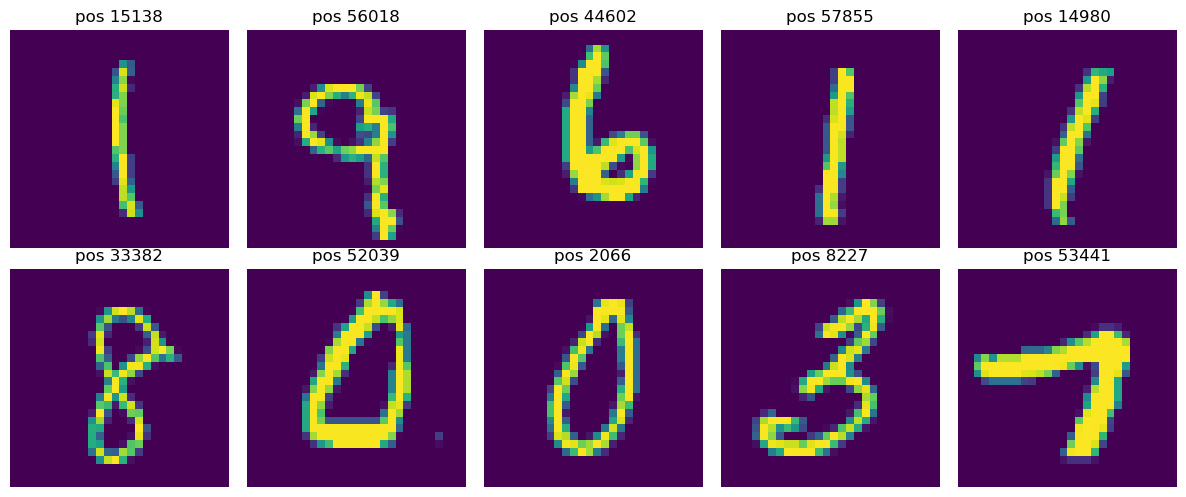

In [4]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12,5))
ax = ax.flatten() # pour transformer notre tableau bidimensionnel en un tableau unidimensionnel

nblin = len(X_train) # on trouve le nombre d'échantillons du X_train

for i in range(10) :  # on a 10 places (2x5) pour afficher des chiffres
    n = rnd.randint(0,nblin)
    ax[i].imshow(X_train[n])
    ax[i].set_title ('pos {}'.format(n))
    ax[i].axis('off')

plt.tight_layout()
plt.show()


et notre Y ? que contient-il ?

In [5]:
print('type :',type(y_train), type(y_test))
print('element position 0: train',y_train[0], 'test', y_test[0])

type : <class 'numpy.ndarray'> <class 'numpy.ndarray'>
element position 0: train 5 test 7


## Préparation ensembles de test et d'entraînement

On va préparer nos images pour l'entraînement et le test. Pour cela, on va les "*aplatir*", c'est-à-dire : au lieu d'avoir une image de 28x28, on va les transformer dans une séquence de 784 pixels.

In [6]:
X_train.shape

(60000, 28, 28)

La première position du shape nous donne le nombre des lignes (échantillons dans notre ensemble de train), les deux autres la largeur et l'hauteur des images. 

In [7]:
num_pixels = X_train.shape[1] * X_train.shape[2] 
num_pixels

784

On garde la première dimension (nombre de lignes), mais on applatit le reste en 784 pixels (valeur qui est dans la variable `num_pixels`). 

In [8]:
X_train = X_train.reshape(X_train.shape[0], num_pixels).astype('float32')
X_test = X_test.reshape(X_test.shape[0], num_pixels).astype('float32')

print('dimensions X train : ',X_train.shape)
print('dimensions X test : ',X_test.shape)

dimensions X train :  (60000, 784)
dimensions X test :  (10000, 784)


On peut aussi normaliser l'ensemble de manière à avoir des valeurs entre 0 et 1 (ce qui va permettre au modèle d'être plus performant).

In [9]:
X_train = X_train / 255
X_test = X_test / 255

Ces modifications ne changent en rien le contenu (les pixels de l'image). La preuve, on peut encore afficher les images comme avant...

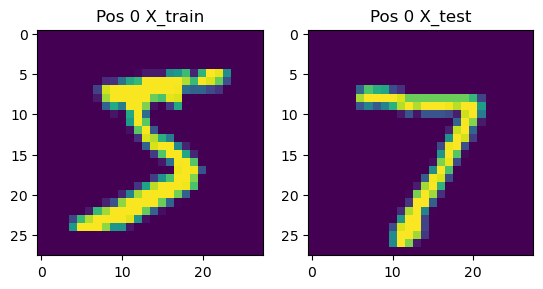

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=2)

ax[0].imshow(X_train[0].reshape(28,28))
ax[0].set_title('Pos 0 X_train')
ax[1].imshow(X_test[0].reshape(28,28))
ax[1].set_title('Pos 0 X_test')

plt.show()

Du même, notre ensemble Y doit également être préparé. Nous avons un problème de classification "*multi-classes*", puisque nous avons plusieurs classes possibles, correspondant aux chiffres 0 à 9. 

L'idéal pour nous serait de savoir quelle est la probabilité d'une image appartenir à une de ces classes. En sortie, on ne veut donc pas juste une classe, mais *la probabilité pour chaque classe*.   

Pour cela, on doit *encoder* notre Y pour que le layer *output* de notre réseau puisse donner la probabilité pour chaque classe. On va ainsi utiliser un encodeur qui est fournit avec Keras, le `to_categorical`, qu'on utilisera sur les ensemble Y train et test.    

In [11]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

print('dimensions y train : ',y_train.shape)
print('dimensions y test : ',y_test.shape)

num_classes = y_test.shape[1]
print('nb de classes :', num_classes)

dimensions y train :  (60000, 10)
dimensions y test :  (10000, 10)
nb de classes : 10


In [12]:
print ('element position 0 : train', y_train[0])
print ('element position 0 : test', y_test[0])

element position 0 : train [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
element position 0 : test [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


## Configuration du réseau

On va essayer d'entraîner un **Réseau de neurones dense** (***RNN***) à l'aide de Keras. Pour cela, on va préparer un modèle dit `Sequential`, dans lequel les couches se succèdent les unes après les autres. 

Pour cet exemple, nous allons réaliser un **réseau dense** de deux niveaux. Dans un réseau dense chaque layer totalement connecté au layer suivant. La classe `Dense` proposée par **Keras** nous offre cette possibilité. Lorsqu'on va créer un objet `Dense`, on doit lui indiquer tout d'abord combien des neurones le layer doit comporter. Pour le premier layer (***input layer***), il s'agit du nombre de *features* (dans notre cas, notre nombre de pixels).

Pour le premier niveau (***input layer***), on doit indiquer la *forme* de l'entrée (taille pour chaque dimension). Dans notre cas, il s'agit à nouveau de notre `num_pixel`, pour lui dire qu'il aura en entrée un tableau de 728 pixels à analyser. 

Pour chaque layer, on doit indiquer la ***fonction d'activation***. On observe donc que, contrairement à SKLearn, ici on peut configurer des ***hidden layers*** avec des fonctions d'activation distinctes. Dans notre exemple, on va utiliser uniquement la fonction `ReLu`, très couramment utilisée comme fonction d'activation pour les ***hidden layers***. 

Pour le dernier niveau (***output***), on aura besoin d'une fonction d'activation différente, la fonction `SoftMax` qui va nous donner une probabilité pour chaque classe. 

*Attention* : on doit avoir autant de neurones à l'***output layer*** que des classes. 


In [13]:
#on va créer le modèle vide, puis on lui ajoute les layers
model = Sequential()   
# input layer : nb neurones , fct activation, forme de l'entrée  
model.add(Dense(num_pixels, activation='relu', input_shape=(num_pixels,)))

# hidden layers : nb neurones , fct activation
model.add(Dense(100, activation='relu'))
model.add(Dense(100, activation='relu'))

# output layer : nb neurones (nb de classes), fct activation 
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 784)               615440    
                                                                 
 dense_1 (Dense)             (None, 100)               78500     
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 dense_3 (Dense)             (None, 10)                1010      
                                                                 
Total params: 705050 (2.69 MB)
Trainable params: 705050 (2.69 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Une fois le modèle créé, on va le "***compiler***", c'est-à-dire connecter les niveaux les uns aux autres, puis établir l'*optimizer* et la fonction *loss* qui seront utilisés pour guider la phase de *backpropagation*. On définit également une (ou plusieurs) métriques qui seront utilisées par le modèle pour l'évaluer. S'agissant d'un problème de classification multi-classes, on va se contenter d'utiliser l'***accuracy*** puisque cette métrique est la plus adaptée à ces cas. 

In [14]:
# compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# model.summary()

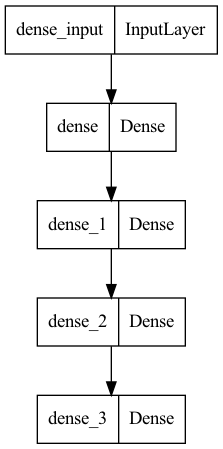

In [15]:
# besoin d'une bibliothèque supplémentaire, pydot
#!pip install pydot
plot_model(model=model)

## Entraînement du modèle

Une fois le modèle prêt (*configuré* et *compilé*), on peut enfin l'entraîner avec la fonction `fit`, puis l'évaluer avec la fonction `evaluate`. 

Lors de l'entraînement (`fit`), on va transmettre au modèle les ensembles X et Y train, mais aussi ceux de test, puisqu'il utilisera ces ensemble pour évaluer les progrès des différents passages d'entraînement (***epoch***).

On doit également indiquer le nombre d'***epochs*** à réaliser. 

In [16]:
# fit the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=12, verbose=True)


Epoch 1/12
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1998 - accuracy: 0.9393 - val_loss: 0.1068 - val_accuracy: 0.9675
Epoch 2/12
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0857 - accuracy: 0.9729 - val_loss: 0.0711 - val_accuracy: 0.9770
Epoch 3/12
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0589 - accuracy: 0.9812 - val_loss: 0.0764 - val_accuracy: 0.9774
Epoch 4/12
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0451 - accuracy: 0.9855 - val_loss: 0.0770 - val_accuracy: 0.9793
Epoch 5/12
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0360 - accuracy: 0.9887 - val_loss: 0.0725 - val_accuracy: 0.9791
Epoch 6/12
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0303 - accuracy: 0.9904 - val_loss: 0.0759 - val_accuracy: 0.9803
Epoch 7/12
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0292 - accuracy: 0.9909 - val_loss: 0.0713 - val_accuracy:

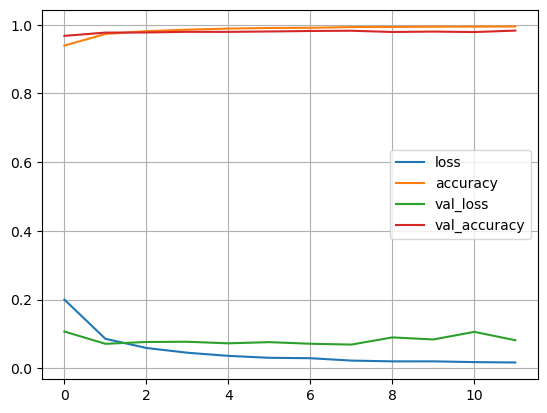

In [17]:
df_hist = pnd.DataFrame(history.history)
df_hist.plot()
plt.grid(True)
plt.show()

## Evaluation du modèle

La fonction `evaluate` permet d'évaluer le modèle avec un ensemble de test (*X_test* et *y_test*). On utilisera les métriques indiquées dans le `compile`. 

Cette fonction retournera un tableau avec la valeur du "***loss***" et celles des métriques choisies (ici "***accuracy***").

In [18]:
# evaluate the model
scores = model.evaluate(X_test, y_test, verbose=True)

print(scores)

313/313 [==============================] - 0s 1ms/step - loss: 0.0815 - accuracy: 0.9828
[0.08152861893177032, 0.9828000068664551]


La classe `model` possède, comme dans **SKLearn**, la méthode `predict`, laquelle permet d'utiliser le modèle pour faire des prédictions. 



In [19]:
y_test_pred = model.predict(X_test)

print (y_test_pred.shape)
print (y_test_pred[0:2])

313/313 [==============================] - 0s 1ms/step
(10000, 10)
[[9.9131357e-16 1.4964446e-10 1.5018136e-11 1.8617345e-13 1.3382169e-11
  2.2511534e-16 2.0402027e-18 9.9999994e-01 3.0671179e-16 1.9294957e-08]
 [1.7264289e-22 2.3307318e-14 9.9999994e-01 1.4150503e-13 1.0780256e-21
  2.0774314e-23 3.8860336e-27 6.5505833e-16 2.4454068e-21 3.5001099e-26]]


Comme pour toute classification, on peut avoir envie d'utiliser les mêmes métriques qu'on avait dans **SKLearn**. 

C'est possible, mais pour cela, on va devoir d'abord travailler notre ensemble Y (aussi bien celui de test que le résultat de notre prédiction), puisque le réseau ne donne pas directement une classe, mais les *probabilités* de chaque classe. 

On va donc aller chercher dans la sortie, la colonne (indiquant la classe) qui compte la plus grosse probabilité. Ceci est possible grâce à l'opération `argmax` de **NumPy**.  

In [20]:
y_pred = y_test_pred.argmax(axis=1)

print (y_pred.shape)
print (y_pred[0:2])

(10000,)
[7 2]


In [21]:
print (y_test.shape)
print (y_test[0:2])

y_true = y_test.argmax(axis=1)

print (y_true.shape)
print (y_true[0:2])

(10000, 10)
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]
(10000,)
[7 2]


              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.99      0.97      0.98      1010
           4       0.98      0.98      0.98       982
           5       0.97      0.98      0.98       892
           6       0.99      0.99      0.99       958
           7       0.98      0.99      0.99      1028
           8       0.99      0.96      0.98       974
           9       0.96      0.99      0.98      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



Text(0.5, 1.0, 'Confusion matrix')

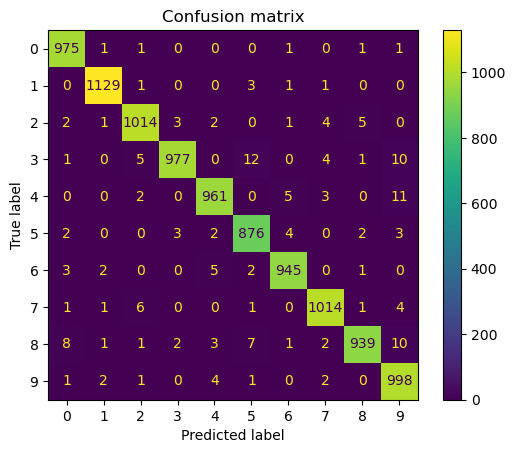

In [22]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

rep = classification_report(y_true=y_true, y_pred=y_pred)
print(rep)

cm = confusion_matrix(y_true=y_true, y_pred=y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Confusion matrix')
